In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt
# turn off svg text as curves
plt.rcParams['svg.fonttype'] = 'none'
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

from os import path
from glob import glob

import pingouin as pg

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
OVERWRITE = True
np.random.seed(42)

In [3]:
color_palette = {
 'Color': 'tab:orange', 
 'Motion': 'tab:green',
 }

In [4]:
experiment_name = "data/preprocessed"
data_dir = f"../{experiment_name}"

conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

DROP_CHANS = ['Fp1', 'Fp2', 'TP9', 'StimTrak']
# EYE_CHANS = ['HEOG', 'VEOG', 'xpos_left', 'xpos_right', 'ypos_left', 'ypos_right']
EOG_CHANS = ['HEOG', 'VEOG']
EYE_CHANS = ['xpos_left', 'xpos_right', 'ypos_left', 'ypos_right']



sub_makeup_error_trials = {1: 1}  # after exclusion, the last n trials which need to be recovered, for now. NOTE: this depends on 


times = np.linspace(-400, 1400, 901)
trim_idx = (times >= -250) & (times <= 1000)  # for trimming EEG down
times = times[trim_idx]

# details for compressing down the time bins, for faster computation
bin_starts = times[::5][:-1]
t_idx_starts = np.where([t in bin_starts for t in times])[0]

# defining delay period, excluding window when numbers never could have appeared
bin_ends = bin_starts+10
delay_period = (bin_starts >= 250) & (bin_ends <=900)

In [5]:
time_window = 10 
time_step = 10
trial_bin_size = 15
n_splits = 1000
group_dict = OrderedDict([('M2N',[102]),('M4N',[104]), ('M6N',[106]),('M8N',[108]),
                          ('M2P',[112]),('M4P',[114]), ('M6P',[116]),('M8P',[118]),
                          ('A2N',[202]),('A4N',[204]), ('A6N',[206]),('A8N',[208]),
                          ('A2P',[212]),('A4P',[214]), ('A6P',[216]),('A8P',[218]),
                          ])

In [6]:
sub_files = sorted(glob(path.join(data_dir, '*', '*_epo.npy')))
nsub = len(sub_files)
sub_files

['../data/preprocessed/001/001_epo.npy',
 '../data/preprocessed/003/003_epo.npy',
 '../data/preprocessed/004/004_epo.npy',
 '../data/preprocessed/005/005_epo.npy',
 '../data/preprocessed/007/007_epo.npy',
 '../data/preprocessed/008/008_epo.npy',
 '../data/preprocessed/009/009_epo.npy',
 '../data/preprocessed/010/010_epo.npy',
 '../data/preprocessed/011/011_epo.npy',
 '../data/preprocessed/013/013_epo.npy',
 '../data/preprocessed/014/014_epo.npy',
 '../data/preprocessed/015/015_epo.npy',
 '../data/preprocessed/019/019_epo.npy',
 '../data/preprocessed/021/021_epo.npy',
 '../data/preprocessed/022/022_epo.npy',
 '../data/preprocessed/023/023_epo.npy',
 '../data/preprocessed/025/025_epo.npy',
 '../data/preprocessed/026/026_epo.npy',
 '../data/preprocessed/027/027_epo.npy',
 '../data/preprocessed/028/028_epo.npy',
 '../data/preprocessed/029/029_epo.npy',
 '../data/preprocessed/030/030_epo.npy',
 '../data/preprocessed/031/031_epo.npy',
 '../data/preprocessed/032/032_epo.npy',
 '../data/prepro

In [7]:
training_labels = ['M2P', 'M4P']
subtitle = 'WM_2vs4_wP'

In [8]:
if OVERWRITE:
    wrangl = eeg_decoder.Wrangler(times,time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
    clfr = eeg_decoder.Classification(wrangl,nsub)
    clfr_eog = eeg_decoder.Classification(wrangl,nsub)
    clfr_eye = eeg_decoder.Classification(wrangl,nsub)

    isub_map = {}
    bad_eog_subs = []
    bad_eye_subs = []
    for isub, xfile in enumerate(sub_files):
        subid = int(xfile.split('/')[-2])

        isub_map[isub] = subid

        print(isub, subid)
        xdata = np.load(xfile)  # NOTE: contains both eeg and eyetracking data
        chans = pd.read_csv(xfile.replace('_epo.npy', '_chan_labels.csv'), header=None, names=['idx', 'labels'])
        assert np.all(chans.index == chans.loc[:, 'idx'])
        keep_idx = chans.loc[~chans['labels'].isin(DROP_CHANS)].index.values
        
        xdata = xdata[:, keep_idx, :]  # remove eye tracking, eog, TP9, and any bad channels (Fp1, Fp2)
        xdata = xdata[:, :, trim_idx]

        # mark the new location of the eeg/eog/eyetracking channels
        chans_post_drop = chans.loc[keep_idx].reset_index(drop=True)
        eog_idx = chans_post_drop.loc[chans_post_drop['labels'].isin(EOG_CHANS)].index.values
        eye_idx = chans_post_drop.loc[chans_post_drop['labels'].isin(EYE_CHANS)].index.values
        eeg_idx = np.setdiff1d(np.arange(xdata.shape[1]), np.concatenate([eog_idx, eye_idx]))


        beh = pd.read_csv(xfile.replace('_epo.npy', '_data.csv'))
        if subid == 10:
            beh = beh.iloc[4:]  # first 4 trials weren't recorded for this sub
        beh = beh.loc[~(beh.REJ==1)] # remove real time eye tracking rejects, which aren't in the EEG
        if path.exists(xfile.replace('_epo.npy', '_preArt_selections.npy')):  # sometimes epoching fails, so we need to use the preArt selections to drop those trials
            preArt_selections = np.load(xfile.replace('_epo.npy', '_preArt_selections.npy'))
            beh = beh.iloc[preArt_selections]

        artifact_idx = np.load(xfile.replace('_epo.npy', '_rej_FINAL.npy'))
        artifact_idx = ~artifact_idx.astype(bool)


        xdata = xdata[artifact_idx]  # remove EEG artifact trials
        beh = beh.loc[artifact_idx]

        # more sub-specific adjustments
        if subid==1:  # sub 1 had weird makeup trials, with values in wrong columns
            to_replace = beh['trial_condition'].isnull().values
            beh.loc[to_replace, 'trial_condition'] = beh['relevant_probe_bin'].values[to_replace]

        if subid==2:  # sub 002 has a messed up makeup attention block
            bad_makeup = np.array([c=='nan' for c in beh['trial_condition'].values])
            beh = beh.loc[~bad_makeup]
            xdata = xdata[~bad_makeup]

        # exclude trials where numbers appears
        numbers_absent = (beh.target_present==0).values
        xdata = xdata[numbers_absent]
        beh = beh.loc[numbers_absent]

        # get ydata
        ydata = beh['trial_condition'].map(group_dict).values
        ydata = np.array([i[0] for i in ydata])  # flatten

        # decide before iterating whether we can use eog/eye data
        # not all subs have all channels
        # futher, one sub had bad eye tracking data which produces nans
        if (len(eog_idx) > 0) and (np.isnan(xdata[:, eog_idx]).sum()==0):
            fit_eog = True
        else:
            fit_eog = False
            bad_eog_subs.append(isub)

        if (len(eye_idx) > 0) and (np.isnan(xdata[:, eye_idx]).sum()==0):
            fit_eye = True
        else:
            fit_eye = False
            bad_eye_subs.append(isub)



        xdata,ydata = wrangl.group_labels(xdata,ydata)    
        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata, train_labels=training_labels):

            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
            
        
            # shuffle test labels within condition
            test_M_N = (y_test==0) | (y_test==1)
            test_M_P = (y_test==4) | (y_test==5)
            test_A_N = (y_test==8) | (y_test==9)
            test_A_P = (y_test==12) | (y_test==13)
            
            y_test_shuffle = np.copy(y_test)
            y_test_shuffle[test_M_N] = np.random.permutation(y_test[test_M_N])
            y_test_shuffle[test_M_P] = np.random.permutation(y_test[test_M_P])
            y_test_shuffle[test_A_N] = np.random.permutation(y_test[test_A_N])
            y_test_shuffle[test_A_P] = np.random.permutation(y_test[test_A_P])



            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                # separate EEG and eye data
                X_train_eeg = X_train[:, :30]
                X_test_eeg = X_test[:, :30]
                clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)

                # if they have eye data, decode that too
                if fit_eog:
                    X_train_eog = X_train[:, eog_idx]
                    X_test_eog = X_test[:, eog_idx]
                    clfr_eog.decode(X_train_eog,X_test_eog,y_train,y_test,y_test_shuffle,isub)
                    
                if fit_eye:
                    X_train_eye = X_train[:, eye_idx]
                    X_test_eye = X_test[:, eye_idx]
                    clfr_eye.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)

    interp = eeg_decoder.Interpreter(clfr, subtitle=subtitle) 
    interp.save_results(timestamp=False)

    interp_eog = eeg_decoder.Interpreter(clfr_eog, subtitle=subtitle+'_eog')
    interp_eog.save_results(timestamp=False)
    print(bad_eog_subs)

    interp_eyes = eeg_decoder.Interpreter(clfr_eye, subtitle=subtitle+'_eyes')
    interp_eyes.save_results(timestamp=False)
    print(bad_eye_subs)

In [9]:
interp = eeg_decoder.Interpreter()
interp.load_results(subtitle)
full_confidence_scores = np.copy(interp.confidence_scores)

In [10]:
colors = [
    # 4 shades of increasing darkness for each color: orange, red, green, blue
    'bisque', 'sandybrown', 'orange', 'darkorange', 
    'lightcoral', 'indianred', 'firebrick', 'darkred',
    'lightgreen', 'limegreen', 'forestgreen', 'darkgreen',
    'lightblue', 'skyblue', 'royalblue', 'darkblue'
]

color_map = {cond: color for cond, color in zip(conditions, colors)}

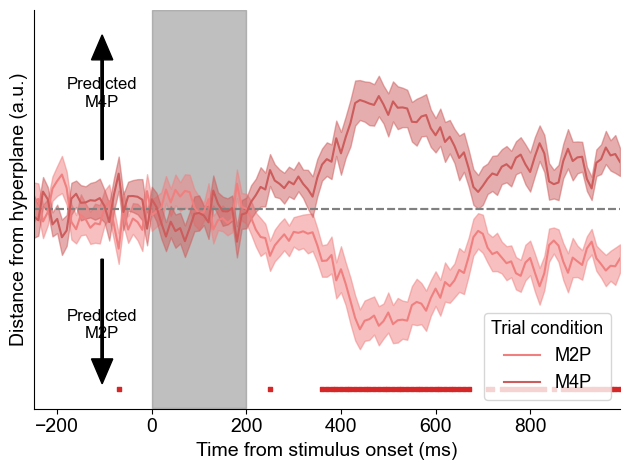

In [11]:
curr_conds = ['M2P', 'M4P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
fig = interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-2,2],stim_label_xy=[130,3.1],label_text_ys=[-1,1],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank')

# add significance markers comparing the 2 conditions
MP_contrast = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]
MP_contrast = MP_contrast.mean(axis=2) # mean across permutations

_, pvals = sista.ttest_1samp(MP_contrast, 0, axis=0, alternative="greater")
_, corrected_p, _, _ = multipletests(pvals, method='fdr_bh')
sig05 = corrected_p < 0.05
plt.scatter(
    interp.t[sig05],
    np.ones(sum(sig05))*-1.8,
    marker="s",
    s=10,
    c='tab:red'
)

plt.tight_layout()
plt.savefig(f'output/figures/{subtitle}_hyperplane.svg')

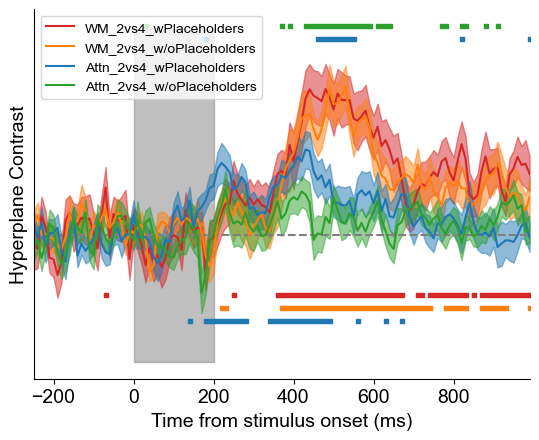

In [12]:
curr_conds = ['M2P', 'M4P', 'M2N', 'M4N', 'A2P', 'A4P', 'A2N', 'A4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds

MP_contrast = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]
MP_contrast = MP_contrast.mean(axis=2) # mean across permutations

MN_contrast = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]
MN_contrast = MN_contrast.mean(axis=2) # mean across permutations

AP_contrast = interp.confidence_scores[..., 5] - interp.confidence_scores[..., 4]
AP_contrast = AP_contrast.mean(axis=2) # mean across permutations

AN_contrast = interp.confidence_scores[..., 7] - interp.confidence_scores[..., 6]
AN_contrast = AN_contrast.mean(axis=2) # mean across permutations

ylim = [-2, 3.25]
stim_time = [0, 200]

cond_scores = [MP_contrast, MN_contrast, AP_contrast, AN_contrast]
labels = ['WM_2vs4_wPlaceholders', 'WM_2vs4_w/oPlaceholders', 'Attn_2vs4_wPlaceholders', 'Attn_2vs4_w/oPlaceholders']
color_palette = {'WM_2vs4_wPlaceholders': 'tab:red', 'WM_2vs4_w/oPlaceholders': 'tab:orange', 'Attn_2vs4_wPlaceholders': 'tab:blue', 'Attn_2vs4_w/oPlaceholders': 'tab:green'}

stim_lower = ylim[0]
stim_upper = ylim[1]

ax = plt.subplot(111)
ax.fill_between(
        stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
    )

ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

for i, curr_scores in enumerate(cond_scores):

    mean, upper, lower = interp.get_plot_line(curr_scores)
    ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
    ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

    _, ps = sista.ttest_1samp(curr_scores, 0, axis=0, alternative="greater")  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*-.2*(i+1)-.75,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

# test if each of the last 3 scores are different from the 1 score

for i in range(1,4):

    _, ps = sista.ttest_rel(cond_scores[i], cond_scores[0], axis=0)  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*.2*(i+1)+2.5,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

plt.yticks([])
plt.ylabel('Hyperplane Contrast', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.xlim(-250, max(interp.t))

sns.despine()
_ = plt.legend()
plt.savefig(f'output/figures/{subtitle}_contrasts.svg', format='svg')

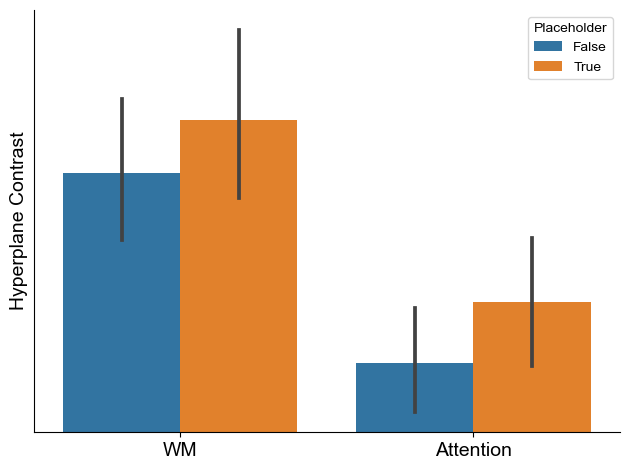

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Task,12.392483,1,25,12.392483,33.997510,0.000004,0.000004,0.212248,1.0
1,Placeholder,1.163952,1,25,1.163952,4.180258,0.051563,0.051563,0.024682,1.0
2,Task * Placeholder,0.005398,1,25,0.005398,0.021502,0.884597,0.884597,0.000117,1.0


In [13]:
window = (interp.t>200) & (interp.t<=1000)

MP_df = pd.DataFrame(MP_contrast[:, window].mean(1), columns=['Hyperplane Contrast'])
MP_df['Task'] = 'WM'
MP_df['Placeholder'] = True
MP_df['subject'] = MP_df.index
MP_df['color_name'] = 'WM_2vs4_wPlaceholders'

MN_df = pd.DataFrame(MN_contrast[:, window].mean(1), columns=['Hyperplane Contrast'])
MN_df['Task'] = 'WM'
MN_df['Placeholder'] = False
MN_df['subject'] = MN_df.index
MN_df['color_name'] = 'WM_2vs4_w/oPlaceholders'

AP_df = pd.DataFrame(AP_contrast[:, window].mean(1), columns=['Hyperplane Contrast'])
AP_df['Task'] = 'Attention'
AP_df['Placeholder'] = True
AP_df['subject'] = AP_df.index
AP_df['color_name'] = 'Attn_2vs4_wPlaceholders'

AN_df = pd.DataFrame(AN_contrast[:, window].mean(1), columns=['Hyperplane Contrast'])
AN_df['Task'] = 'Attention'
AN_df['Placeholder'] = False
AN_df['subject'] = AN_df.index
AN_df['color_name'] = 'Attn_2vs4_w/oPlaceholders'

all_df = pd.concat([MP_df, MN_df, AP_df, AN_df])
all_df

_ = sns.barplot(x=all_df['Task'], y=all_df['Hyperplane Contrast'], hue=all_df['Placeholder'])
sns.despine()
plt.yticks([])
plt.ylabel('Hyperplane Contrast', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('')

plt.tight_layout()
plt.savefig(f'output/figures/{subtitle}_ANOVA_barplot.svg', format='svg')
plt.show()
pg.rm_anova(all_df, dv='Hyperplane Contrast', within=['Task', 'Placeholder'], subject='subject')

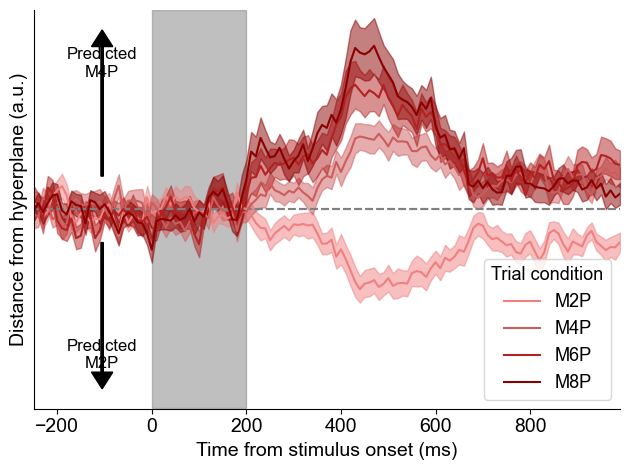

In [22]:
curr_conds = ['M2P', 'M4P', 'M6P', 'M8P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank')


plt.show()
plt.close()

1 2.539381082295535e-07
2 2.5246721908205324e-08
3 4.030232126432934e-08
2 0.0018333096034870403
3 0.0008401987482755307


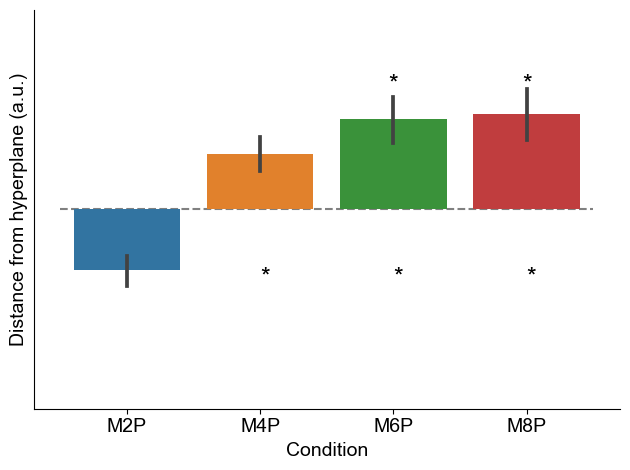

In [25]:
# building up to barplots across the average delay period
curr_cs = interp.confidence_scores.mean(2)
curr_cs = curr_cs[:, interp.t>200, :].mean(1)
curr_cs.shape
full_df = pd.DataFrame(curr_cs, columns=curr_conds)
full_df['subject'] = full_df.index.values
melted_df = full_df.melt(id_vars='subject', var_name='condition', value_name='distance')
melted_df
# plt.plot(, np.zeros((len(interp.t))), "--", color="gray")
ax = sns.barplot(data=melted_df, x='condition', y='distance')
ax.hlines(0, -0.5, 3.5, color='gray', linestyle='--', zorder=-1)

# Add t-tests agains the first 2 conditions
# test cond 0 against the other 1-3
for i in range(1,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 0], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, -.75, '*', fontsize=18)

    if (p>=.05) & (p<.1):
        plt.text(i, 1.5, '+', fontsize=18)

# test cond 1 against 2-3
for i in range(2,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 1], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, 1.25, '*', fontsize=18, ha='center', va='center')

    if (p>=.05) & (p<.1):
        plt.text(i, 1.25, '+', fontsize=18, ha='center', va='center')

# get rid of yticks and labels
plt.ylim(-2, 2)
_ = plt.yticks([])
_ = plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)
# change xticks fontsize
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Condition', fontsize=14)

_ = sns.despine()
plt.tight_layout()
plt.savefig('output/figures/WM_2vs4_wP_delay_period.svg')  
plt.show()
plt.close()

# just checking what the other conditions look like on the original hyperplanes

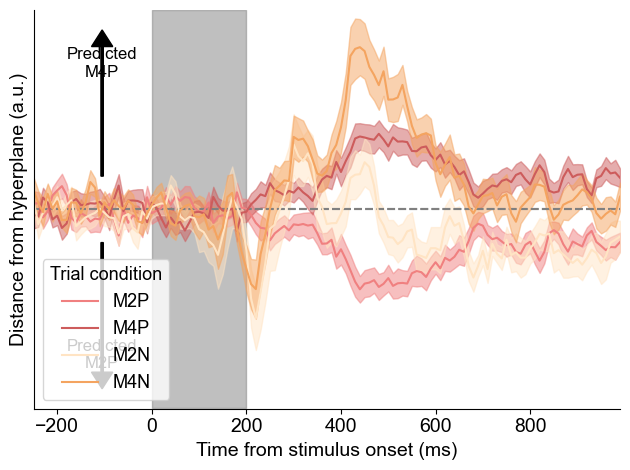

In [16]:
curr_conds = ['M2P', 'M4P', 'M2N', 'M4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

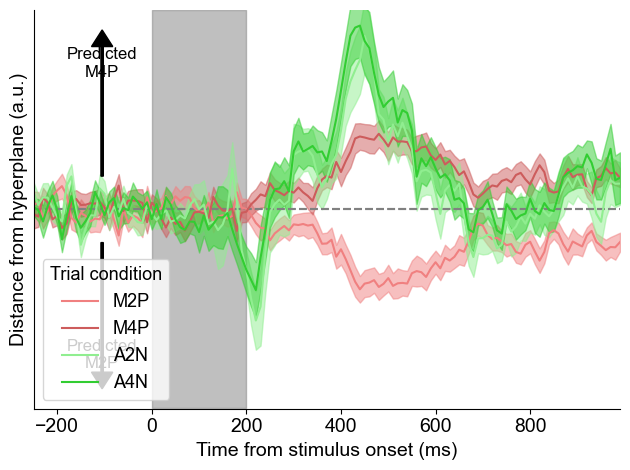

In [17]:
curr_conds = ['M2P', 'M4P', 'A2N', 'A4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

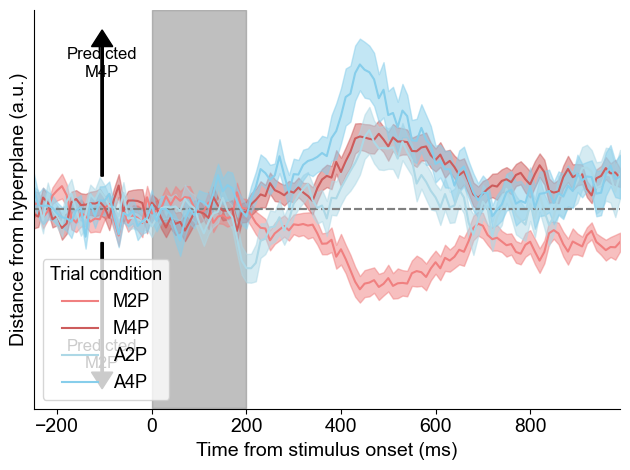

In [18]:
curr_conds = ['M2P', 'M4P', 'A2P', 'A4P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

In [19]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)